In [68]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale
import scipy
from scipy.special import expit
import pytensor.tensor as pt
import graphviz
from sklearn.linear_model import LinearRegression
import rdata

## Missing Data

An observed variable is very unusual 

Missing data is typical. If not normal

Observed data is special case: We trick ourselves into believing there is no error

Most data are missing most of the time

"Missing" data: Some cases unobserved

Not totally "missing": We know

1) constraints

2) relationships to other variables (through the causal model)

## Missing Data is Workflow

What to do with missing data?

Dropping cases with missing values sometimes justifiable

Right thing to do depends upon causal assumptions

Imputation often beneficial/necessary

In [2]:
H = graphviz.Digraph()
H.edge('S','H') # Student -> Homework
H.edge('H','H*') # Descendent, has missing values of peopel who didn't turn in hw
H.edge('D','H*') #Dog eating HW! 
H
#"Dog eats random homework"
#No biasing paths connecting H to S

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

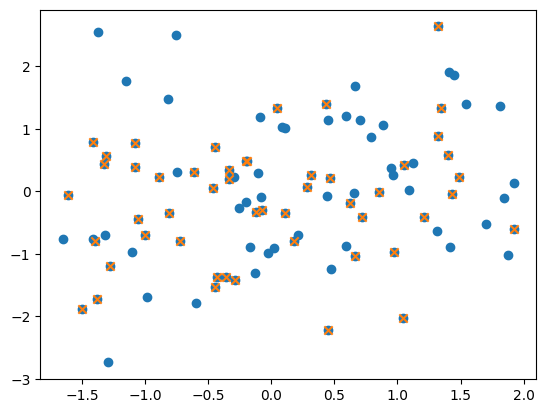

In [77]:
N = 100
S = np.random.normal(size=100)
H = np.random.normal(0.5*S,size=100)

D = np.random.binomial(1,0.5,size=100)

Hstar = H.copy()
Hstar[D==1] = np.NaN


plt.scatter(S,H,marker='o')
plt.scatter(S,Hstar,marker='x')


#Fitting a line through both sets will result in basically the same result
#Loss of precision, usually no bias

In [65]:
H = graphviz.Digraph()
H.edge('S','H') # Student -> Homework
H.edge('H','H*') # Descendent, has missing values of peopel who didn't turn in hw
H.edge('D','H*') #Dog eating HW!
H.edge('S','D') #Student influences dog to eat homework! 

#S->D->H* Maybe a biasing path
H

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

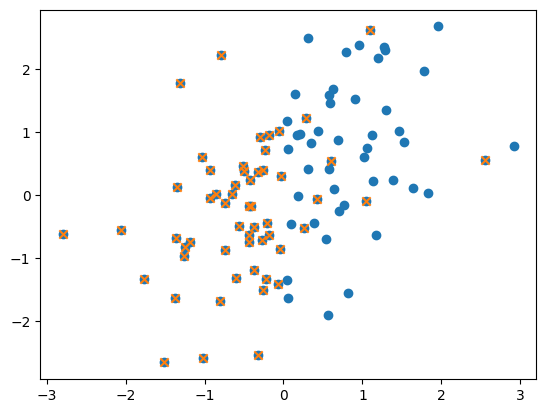

In [67]:
N = 100
S = np.random.normal(size=100)
H = np.random.normal(0.5*S,size=100)

D = np.random.binomial(1,[0.8 if x > 0 else 0 for x in S],size=100)

Hstar = H.copy()
Hstar[D==1] = np.NaN

plt.scatter(S,H,marker='o')
plt.scatter(S,Hstar,marker='x')

#Crosses are observed, 

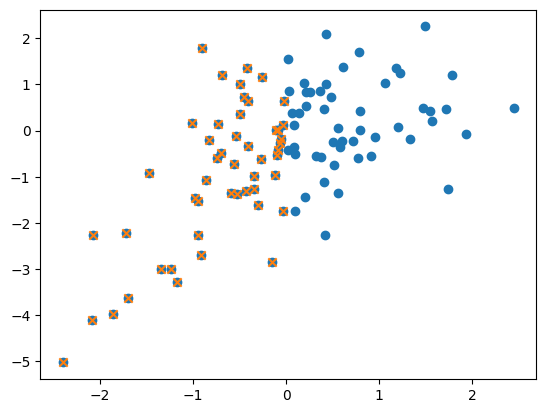

In [80]:
N = 100
S = np.random.normal(size=100)
H = np.random.normal( 1 - np.exp(-0.7*S),size=100)

D = np.random.binomial(1,[1 if x > 0 else 0 for x in S],size=100)

Hstar = H.copy()
Hstar[D==1] = np.NaN

plt.scatter(S,H,marker='o')
plt.scatter(S,Hstar,marker='x')

#Crosses are observed, 
#Look at curve now, 

In [ ]:
H = graphviz.Digraph()
H.edge('S','H') # Student -> Homework
H.edge('H','H*') # Descendent, has missing values of peopel who didn't turn in hw
H.edge('D','H*') #Dog eating HW! 
H.edge('H','D') # Dogs have a preference for homework
H
#"Dog eats ocnditional on homework"
#Usually not benigng

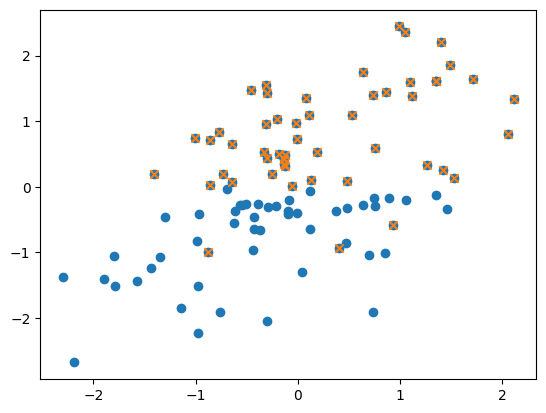

In [81]:
N = 100
S = np.random.normal(size=100)
H = np.random.normal(0.5*S,size=100)

D = np.random.binomial(1,[0.9 if x < 0 else 0 for x in H],size=100)

Hstar = H.copy()
Hstar[D==1] = np.NaN

plt.scatter(S,H,marker='o')
plt.scatter(S,Hstar,marker='x')

#Crosses are observed, 
#Below average hw gets eaten! 

3 Idealized cases

1) Dog eats random homework: Dropping incomplete cases okay, but loss of efficiency

2) Dog eats conditional on cause: Correctly condition on cause

3) Dog eats homework itself: usually hopeless unless we can model the dog (e.g. survival analysis)

Lots of variables where the value itself increases the probability that you will not observe it (i.e. best items get taken from a production site, can't observe the best items!)

Honest thing to do: usually report that 3. is hopeless, can't draw causal conclusions due to the missingness. Not always hopeless

## Bayesian Imputation

1) Dog eats random homework

2) Dog eats conditional on cause

Both imply need to impute or marginalize over missing values

Bayesian Imputation: Compute posterior probability distribution of missing values

Marginalizing unknowns: Averaging over distribution of missing values 

Causal model of all variables implies strategy for imputation

Technical obstacles exist!

Sometimes imputation is unnecessary, e.g. discrete parameters

Sometimes imputation is easier, eg. censored observations

## Phylogenetic regression

data(Primates301)

Life history traits

Mass g, brain cc, group size

Much missing data, measurement error, unobserved confounding